# proposal :
# Understanding the Effect of Fitness on Sleep and Caloric Burn

Ubiquitous self-tracking technologies have penetrated various aspects of our lives, from physical and mental health monitoring to fitness and entertainment. Yet, limited data exist on the association between in the wild large-scale physical activity patterns, sleep, stress, and overall health, and behavioral patterns and psychological measurements due to challenges in collecting and releasing such datasets,Despite limited data, this project will concentrate on exploring the relationship between fitness and two important aspects of health - sleep time and calorie expenditure.

The first question is: Is there a meaningful relationship between the steps taken and distance tracked, and the time spent sleeping and being in bed? In order to answer this question, we will be examining the correlation between the steps taken, distance tracked, and time spent sleeping and in bed. This will give us an understanding of how closely these variables are related, and if there is a significant relationship between them.

The second question is: Is the number of calories burned related to the distance traveled or the number of steps taken? This question is important because it will help us determine which of these two variables has a greater impact on caloric burn. By examining the correlation between the number of calories burned and the number of steps taken or the distance traveled, we can gain a better understanding of the relationship between these variables and the impact they have on caloric burn.

third "I also want to know if there is a relationship between  calories burned and the time spent sleeping. As I want to demonstrate my ability to use chi-square statistics, I categorized my data using standard indicators." 

In conclusion, our focus on these two critical questions will give us a better understanding of the relationship between fitness and sleep time, as well as fitness and caloric burn. This information will help us make informed decisions about how to optimize our fitness routine to improve our overall health and well-being.

These datasets were generated by respondents to a distributed survey via Amazon Mechanical Turk between 03.12.2016-05.12.2016.  Thirty eligible Fitbit users consented to the submission of personal tracker data, including minute-level output for physical activity :https://www.kaggle.com/datasets/arashnic/fitbit "On this website address there are 18 files generated from Fitbit in the Fitabase Data 4.12.16-5.12.16 dataset. I chose three files related to my research questions: dailyActivity_merged.csv (111.29 kB), dailyCalories_merged.csv (25.13 kB), and sleepDay_merged.csv (18.1 kB). For convenience, I changed the file names to dailyActivity.cvs and dailyCalories.cvs and sleepDay.csv "



Libraries

In [398]:

# import necessary libraries 
import pandas as pd
import numpy as np
import yaml
from bokeh.io import output_notebook
output_notebook()
import random
from bokeh.plotting import figure, show, output_file
from bokeh.plotting import ColumnDataSource
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from bokeh.palettes import Category20_20
from sklearn.linear_model import LinearRegression
import panel as pn


Loading BokehJS ...

# Importing datasets

In [399]:

# open cvs files by yaml
with open ("fitbit_config.yaml", "r") as stream:
    fitbit_config = yaml.safe_load(stream)
dailyActivity = fitbit_config["dailyActivity"]
dailyCalories = fitbit_config["dailyCalories"]
sleepDay = fitbit_config["sleepDay"]

dailyActivity = pd.read_csv(dailyActivity)
dailyCalories = pd.read_csv(dailyCalories)
sleepDay = pd.read_csv(sleepDay)
df_dailyActivity = dailyActivity.copy()
df_dailyCalories = dailyCalories.copy()
df_sleepDay = sleepDay.copy()




# Creating needed functions

In [400]:

# cleaning data : drop  columns
def clean_data(df):
    df.drop(columns=df.columns[4:], inplace=True)
    return df


In [401]:
def count_missing_values(df):
    missing_values = df.isna().sum().sum()
    return missing_values

In [402]:
def count_zero_values(df):
    zero_values = (df == 0).sum().sum()
    return zero_values

In [403]:
def count_unique_ids(df):
    unique_ids = set(df)
    return len(unique_ids)

# Cleaning data

In dailyActivity dataset, I have chosen to concentrate specifically on the "distance" and "step" data collected by the Fitbit device. Despite the fact that the remaining columns in the dataset may hold significant insights, they fall outside the parameters of my project and will therefore not be included in my analysis

In [404]:
df_dailyActivity = clean_data(df_dailyActivity)

In [405]:
df_sleepDay['SleepDay'] = pd.to_datetime(df_sleepDay['SleepDay'])
df_sleepDay['SleepDay'] = df_sleepDay['SleepDay'].dt.strftime('%m/%d/%Y')
df_sleepDay

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
0,1503960366,04/12/2016,1,327,346
1,1503960366,04/13/2016,2,384,407
2,1503960366,04/15/2016,1,412,442
3,1503960366,04/16/2016,2,340,367
4,1503960366,04/17/2016,1,700,712
...,...,...,...,...,...
408,8792009665,04/30/2016,1,343,360
409,8792009665,05/01/2016,1,503,527
410,8792009665,05/02/2016,1,415,423
411,8792009665,05/03/2016,1,516,545


In [406]:
df_dailyActivity['ActivityDate'] = pd.to_datetime(df_dailyActivity['ActivityDate'])
df_dailyActivity['ActivityDate'] = df_dailyActivity['ActivityDate'].dt.strftime('%m/%d/%Y')
df_dailyActivity

,Id,ActivityDate,TotalSteps,TotalDistance
0,1503960366,04/12/2016,13162,8.500000
1,1503960366,04/13/2016,10735,6.970000
2,1503960366,04/14/2016,10460,6.740000
3,1503960366,04/15/2016,9762,6.280000
4,1503960366,04/16/2016,12669,8.160000
...,...,...,...,...
935,8877689391,05/08/2016,10686,8.110000
936,8877689391,05/09/2016,20226,18.250000
937,8877689391,05/10/2016,10733,8.150000
938,8877689391,05/11/2016,21420,19.559999


In [407]:
df_dailyCalories['ActivityDay'] = pd.to_datetime(df_dailyCalories['ActivityDay'])
df_dailyCalories['ActivityDay'] = df_dailyCalories['ActivityDay'].dt.strftime('%m/%d/%Y')
df_dailyCalories

,Id,ActivityDay,Calories
0,1503960366,04/12/2016,1985
1,1503960366,04/13/2016,1797
2,1503960366,04/14/2016,1776
3,1503960366,04/15/2016,1745
4,1503960366,04/16/2016,1863
...,...,...,...
935,8877689391,05/08/2016,2847
936,8877689391,05/09/2016,3710
937,8877689391,05/10/2016,2832
938,8877689391,05/11/2016,3832


In [408]:
# to find unique ids which are not in 1 data sets but are in 2 others
not_in_dailyCalories = df_dailyActivity[~df_dailyActivity['Id'].isin(df_dailyActivity['Id'])]['Id'].unique()
not_in_dailyCalories
not_in_sleepDay = df_dailyActivity[~df_dailyActivity['Id'].isin(df_sleepDay['Id'])]['Id'].unique()
not_in_sleepDay

array([1624580081, 2022484408, 2873212765, 3372868164, 4057192912,
       6290855005, 8253242879, 8583815059, 8877689391], dtype=int64)

In [409]:
# I decided to omit the ids in copy_dailyActivity which are not in sleepDay.
df_dailyActivity = df_dailyActivity[~df_dailyActivity['Id'].isin(not_in_sleepDay)]
unique_ids = df_dailyActivity['Id'].nunique()
unique_ids

24

In [410]:
# I decided to omit the ids in copy_dailyCalories which are not in sleepDay
df_dailyCalories = df_dailyCalories[~df_dailyCalories['Id'].isin(not_in_sleepDay)]
unique_ids = df_dailyCalories['Id'].nunique()
unique_ids

24

In [411]:
""" Also when I query on ids which their TotalSteps and TotalDistance are null ,I decided to omit them because
It means on that day they have sedentary life style and didn't do sport and also I want to analyse the effects of  
teken step and distance on sleep time and burnt calory, when both of columns are null it means no activity or fault in 
device so I take out from research  """
mask = (df_dailyActivity['TotalSteps'] == 0) & (df_dailyActivity['TotalDistance'] == 0)
df_dailyActivity = df_dailyActivity[~mask]
print(len(df_dailyActivity))


644


In [412]:
merged_df = df_dailyActivity.merge(df_dailyCalories, left_on=["Id","ActivityDate"], right_on=["Id","ActivityDay"], how='inner')
merged_df

,Id,ActivityDate,TotalSteps,TotalDistance,ActivityDay,Calories
0,1503960366,04/12/2016,13162,8.50,04/12/2016,1985
1,1503960366,04/13/2016,10735,6.97,04/13/2016,1797
2,1503960366,04/14/2016,10460,6.74,04/14/2016,1776
3,1503960366,04/15/2016,9762,6.28,04/15/2016,1745
4,1503960366,04/16/2016,12669,8.16,04/16/2016,1863
...,...,...,...,...,...,...
639,8792009665,04/30/2016,7174,4.59,04/30/2016,2896
640,8792009665,05/01/2016,1619,1.04,05/01/2016,1962
641,8792009665,05/02/2016,1831,1.17,05/02/2016,2015
642,8792009665,05/03/2016,2421,1.55,05/03/2016,2297


# Data Wrangling

""" first I decided to get left join and after that interpolate Nan data but by more processing I found out
by interpolating I manipulate the result because in sleepday dataset there is around 230 raws that there is not any
data for them and if I fill them Ii should fill whole the raw that is not reasonable so I use inner join    """

In [413]:
total_df = merged_df.merge(df_sleepDay, left_on=["Id","ActivityDate"], right_on=["Id","SleepDay"], how="inner")    
total_df                                                                                                                                                                               

,Id,ActivityDate,TotalSteps,TotalDistance,ActivityDay,Calories,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
0,1503960366,04/12/2016,13162,8.50,04/12/2016,1985,04/12/2016,1,327,346
1,1503960366,04/13/2016,10735,6.97,04/13/2016,1797,04/13/2016,2,384,407
2,1503960366,04/15/2016,9762,6.28,04/15/2016,1745,04/15/2016,1,412,442
3,1503960366,04/16/2016,12669,8.16,04/16/2016,1863,04/16/2016,2,340,367
4,1503960366,04/17/2016,9705,6.48,04/17/2016,1728,04/17/2016,1,700,712
...,...,...,...,...,...,...,...,...,...,...
408,8792009665,04/30/2016,7174,4.59,04/30/2016,2896,04/30/2016,1,343,360
409,8792009665,05/01/2016,1619,1.04,05/01/2016,1962,05/01/2016,1,503,527
410,8792009665,05/02/2016,1831,1.17,05/02/2016,2015,05/02/2016,1,415,423
411,8792009665,05/03/2016,2421,1.55,05/03/2016,2297,05/03/2016,1,516,545


In [414]:
total_df['TotalMinutesAsleep'] = total_df['TotalMinutesAsleep'].round().astype(int)
total_df['TotalTimeInBed'] = total_df['TotalTimeInBed'].round().astype(int)

# convert the values in minutes to hours
total_df['TotalMinutesAsleep'] = total_df['TotalMinutesAsleep'] / 60
total_df['TotalTimeInBed'] = total_df['TotalTimeInBed'] / 60

# round the values in the TotalMinutesAsleep and TotalTimeInBed columns to the nearest half
total_df['TotalMinutesAsleep'] = total_df['TotalMinutesAsleep'].round(1)
total_df['TotalTimeInBed'] = total_df['TotalTimeInBed'].round(1)
# rename the TotalMinutesAsleep column to TotalHoursAsleep
total_df = total_df.rename(columns={'TotalMinutesAsleep': 'TotalHoursAsleep'})
total_df

,Id,ActivityDate,TotalSteps,TotalDistance,ActivityDay,Calories,SleepDay,TotalSleepRecords,TotalHoursAsleep,TotalTimeInBed
0,1503960366,04/12/2016,13162,8.50,04/12/2016,1985,04/12/2016,1,5.4,5.8
1,1503960366,04/13/2016,10735,6.97,04/13/2016,1797,04/13/2016,2,6.4,6.8
2,1503960366,04/15/2016,9762,6.28,04/15/2016,1745,04/15/2016,1,6.9,7.4
3,1503960366,04/16/2016,12669,8.16,04/16/2016,1863,04/16/2016,2,5.7,6.1
4,1503960366,04/17/2016,9705,6.48,04/17/2016,1728,04/17/2016,1,11.7,11.9
...,...,...,...,...,...,...,...,...,...,...
408,8792009665,04/30/2016,7174,4.59,04/30/2016,2896,04/30/2016,1,5.7,6.0
409,8792009665,05/01/2016,1619,1.04,05/01/2016,1962,05/01/2016,1,8.4,8.8
410,8792009665,05/02/2016,1831,1.17,05/02/2016,2015,05/02/2016,1,6.9,7.0
411,8792009665,05/03/2016,2421,1.55,05/03/2016,2297,05/03/2016,1,8.6,9.1


I decided to drop two column 'ActivityDay' and 'SleepDay' because they are the same as 	'ActivityDate' and omitting them not only has effect but also make the database cleaner  

In [415]:
total_df = total_df.drop('ActivityDay',axis = 1)
total_df = total_df.drop('SleepDay',axis=1)

To improve the data quality, I  changed the data type of the 'ActivityDate' column to an appropriate format. This will allow for better data analysis and more accurate results.
Additionally, I  converted the date '05/04/2016' to an integer value of '05042016' with a 32-bit data type. This will make it easier to work with the date in various calculations and functions.

In [416]:
total_df['ActivityDate'] = pd.to_datetime(total_df['ActivityDate'], format='%m/%d/%Y')
total_df['ActivityDate'] = total_df['ActivityDate'].dt.strftime('%m%d%Y').astype(int)
print(total_df.dtypes)
total_df

Id                     int64
ActivityDate           int32
TotalSteps             int64
TotalDistance        float64
Calories               int64
TotalSleepRecords      int64
TotalHoursAsleep     float64
TotalTimeInBed       float64
dtype: object


,Id,ActivityDate,TotalSteps,TotalDistance,Calories,TotalSleepRecords,TotalHoursAsleep,TotalTimeInBed
0,1503960366,4122016,13162,8.50,1985,1,5.4,5.8
1,1503960366,4132016,10735,6.97,1797,2,6.4,6.8
2,1503960366,4152016,9762,6.28,1745,1,6.9,7.4
3,1503960366,4162016,12669,8.16,1863,2,5.7,6.1
4,1503960366,4172016,9705,6.48,1728,1,11.7,11.9
...,...,...,...,...,...,...,...,...
408,8792009665,4302016,7174,4.59,2896,1,5.7,6.0
409,8792009665,5012016,1619,1.04,1962,1,8.4,8.8
410,8792009665,5022016,1831,1.17,2015,1,6.9,7.0
411,8792009665,5032016,2421,1.55,2297,1,8.6,9.1


# Data Inspection

In [417]:
missing_values = count_missing_values(total_df)
missing_values
# There is no missing value in 3 datasets 

0

In [418]:
zero_value = count_zero_values(total_df)
zero_value


0

In [419]:
print(total_df.dtypes)

Id                     int64
ActivityDate           int32
TotalSteps             int64
TotalDistance        float64
Calories               int64
TotalSleepRecords      int64
TotalHoursAsleep     float64
TotalTimeInBed       float64
dtype: object


In [420]:
df_without_Idcolumn = total_df.drop(columns=['Id'])
df_without_Idcolumn.describe()

,ActivityDate,TotalSteps,TotalDistance,Calories,TotalSleepRecords,TotalHoursAsleep,TotalTimeInBed
count,4.130000e+02,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000
mean,4.518142e+06,8541.140436,6.038620,2397.573850,1.118644,6.993220,7.640678
std,4.109095e+05,4156.926990,3.051998,762.886326,0.345521,1.972481,2.115280
min,4.122016e+06,17.000000,0.010000,257.000000,1.000000,1.000000,1.000000
25%,4.192016e+06,5206.000000,3.600000,1850.000000,1.000000,6.000000,6.700000
50%,4.272016e+06,8925.000000,6.290000,2220.000000,1.000000,7.200000,7.700000
75%,5.042016e+06,11393.000000,8.030000,2926.000000,1.000000,8.200000,8.800000
max,5.122016e+06,22770.000000,17.540001,4900.000000,3.000000,13.300000,16.000000


    The "TotalSteps" column shows that the average number of steps taken is 8541, with a standard deviation of 4157.
    The "TotalDistance" column shows that the average distance traveled is 6.038620, with a standard deviation of 3.051998.
    The "Calories" column shows that the average number of calories burned is 2397.57, with a standard deviation of 762.89.
    The "TotalSleepRecords" column shows that the average number of sleep records per person is 1.12, with a standard deviation of 0.35.
    The "TotalHoursAsleep" column shows that the average hours of sleep per person is 6.99, with a standard deviation of 1.97.
    The "TotalTimeInBed" column shows that the average time in bed per person is 7.64, with a standard deviation of 2.12.

I want to use correlation to see the relation between columns and I will explained the meaning of the result of correlation

In [421]:
total_df.corr()

,Id,ActivityDate,TotalSteps,TotalDistance,Calories,TotalSleepRecords,TotalHoursAsleep,TotalTimeInBed
Id,1.000000,0.012246,0.011345,0.078405,0.402974,-0.012552,0.079110,0.001396
ActivityDate,0.012246,1.000000,0.008563,0.003624,-0.044155,-0.077617,-0.006417,-0.003566
TotalSteps,0.011345,0.008563,1.000000,0.981533,0.411996,-0.162490,-0.185206,-0.164269
TotalDistance,0.078405,0.003624,0.981533,1.000000,0.527728,-0.144390,-0.170652,-0.158376
Calories,0.402974,-0.044155,0.411996,0.527728,1.000000,-0.051060,-0.028112,-0.133206
TotalSleepRecords,-0.012552,-0.077617,-0.162490,-0.144390,-0.051060,1.000000,0.166074,0.173043
TotalHoursAsleep,0.079110,-0.006417,-0.185206,-0.170652,-0.028112,0.166074,1.000000,0.930289
TotalTimeInBed,0.001396,-0.003566,-0.164269,-0.158376,-0.133206,0.173043,0.930289,1.000000


"""Between TotalSteps and TotalDistance, there is a very strong positive correlation, which is logical.
Between TotalSteps and TotalCalories, there is a positive correlation, but it is not as strong. It appears
that TotalDistance has a greater impact on TotalCalories than TotalSteps.
There is a very weak negative correlation between TotalSteps and TotalDistance with TotalHoursAsleep and TotalTimeInBed.a value between -1 and 1, indicating the strength and direction of the correlation. A value close to 1 indicates a strong positive correlation, a value close to -1 indicates a strong negative correlation, and a value close to 0 indicates no correlation."""

# Assumptions

"My first assumption is that there is a positive relationship between the number of steps taken and the total distance with the number of burnt calories. The more steps and distance covered, the more calories burnt. However, I cannot say whether distance has a greater effect than steps or vice versa. To confirm this, I decided to create a scatter plot to visualize the data spread and get an idea. I chose a scatter plot because my data is vast and spread out, and it is better suited to my data type than other plots."

I made a function in bokeh to make it easier because its repetetive and also for make it interactive I need the function

In [422]:
def create_scatter_plot( x_col="TotalSteps", y_col="Calories"):
    # Create a ColumnDataSource from the DataFrame
    data = ColumnDataSource(total_df)
   
    # Create a new figure
    p = figure(plot_width=300, plot_height=300)

    # Define a list of 20 colors from the Category20 palette
    colors = Category20_20

    # Add a scatter plot to the figure
    p.scatter(x=x_col, y=y_col, source=data, size=8, color=random.choice(colors), alpha=0.5)
    
    p.xaxis.axis_label = x_col
    p.yaxis.axis_label = y_col
    # Show the plot
    return(p)

In [423]:
p = create_scatter_plot("TotalSteps", "Calories")


"The scatter plot I created confirms my assumption that there is a positive relationship between the total number of steps taken and the number of calories burned. The plot clearly shows that as the total number of steps taken increases, the number of burned calories also increases. This suggests that physical activity, as measured by the total number of steps taken, is an important factor in determining the number of calories burned."

In [424]:
p = create_scatter_plot("TotalDistance", "Calories")


"The scatter plot I created confirms my assumption that there is a positive relationship between the TotalDistance and the number of calories burned. The plot clearly shows that as the TotalDistance increases, the number of burned calories also increases. This suggests that physical activity, as measured by the TotalDistance, is an important factor in determining the number of calories burned."

---------------------------------------------------------------------------------------------------------------------

my second assumption :" Based on my knowledge, it is plausible that there could be a negative relationship between the number of steps taken and the total distance with the TotalHoursAsleep and TotalTimeInBed . It is possible that individuals who take more steps and cover greater distances throughout the day may be more physically active and may have more difficulty falling or staying asleep at night due to higher levels of energy or discomfort. Conversely, individuals who take fewer steps and cover less distance may be less physically active and may experience less difficulty falling or staying asleep at night. However, it is important to note that this assumption may not hold true for every individual, as there are many factors that can affect sleep quality and duration. Additional research and data analysis would be necessary to confirm or refute this assumption"

In [425]:
p = create_scatter_plot("TotalDistance", "TotalHoursAsleep")


In [426]:
p = create_scatter_plot("TotalSteps", "TotalHoursAsleep")


"The scatter plot I created shows a negative relationship between the TotalDistance and Total taken steps with the TotalHoursAsleep, which confirms my second assumption. This suggests that as the total distance covered increases, the total hours of sleep tend to decrease. However there may be other factors at play that could affect both the TotalDistance and the TotalHoursAsleep. Further analysis would be necessary to determine the extent of this relationship and its potential causes."

---------------------------------------------------------------------------------------------------------------------

In [427]:
p = create_scatter_plot( "TotalDistance", "TotalTimeInBed")


In [428]:
p = create_scatter_plot( "TotalSteps", "TotalTimeInBed")


"The scatter plot I created shows a negative relationship between the TotalDistance and Total taken steps with TotalTimeInBed , which confirms my second assumption. This suggests that as the total distance and taken steps covered increases, the TotalTimeInBed tend to decrease. However there may be other factors at play that could affect both the TotalDistance and the TotalTimeInBed. Further analysis would be necessary to determine the extent of this relationship and its potential causes."

In [429]:

list1=['TotalDistance','TotalSteps']
list2=['TotalTimeInBed','Calories','TotalHoursAsleep']
interact_scatter =val_anti = pn.interact(create_scatter_plot, x_col=list1, y_col=list2)
pn.Row(interact_scatter)

BokehModel(combine_events=True, render_bundle={'docs_json': {'1fda68da-70a0-4bce-a62f-e6aa8df2d714': {'defs': …

Row(sizing_mode='stretch_width')
    [0] Column(sizing_mode='stretch_width')
        [0] Column(sizing_mode='stretch_width')
            [0] Select(name='x_col', options=['TotalDistance', ...], sizing_mode='stretch_width', value='TotalSteps')
            [1] Select(name='y_col', options=['TotalTimeInBed', ...], sizing_mode='stretch_width', value='Calories')
        [1] Row(sizing_mode='stretch_width')
            [0] Bokeh(Figure, name='interactive00452', sizing_mode='stretch_width')

---------------------------------------------------------------------------------------------------------------------

"I used the total_df.corr() method to calculate the correlation matrix of the DataFrame, but I also used the heatmap function from the Seaborn library to create a graphical representation of the correlations between variables. The heatmap uses a color scale to show the strength and direction of the correlations, which makes it easier to visually identify patterns and relationships between variables."


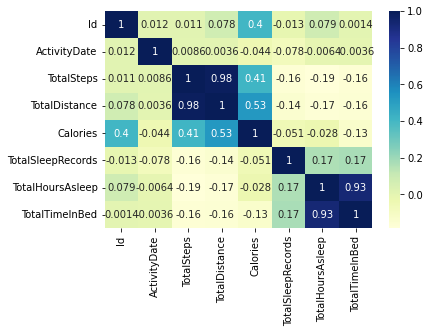

In [430]:
sns.heatmap(total_df.corr(), cmap="YlGnBu", annot=True)
plt.show()

"I used both the heatmap function and total_df.corr() method to visualize the correlation between variables in my dataset, and both produced the same results. However, I also wrote the correlation function from scratch to better understand the meaning of correlation and how it's calculated. Although the result was the same, it helped me gain a deeper understanding of the concept."


In [431]:
def pearson_correlation(df, column1, column2):
    x = df[column1]
    y = df[column2]
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    x_standard_deviation = np.std(x)
    y_standard_deviation = np.std(y)
    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = len(x) * x_standard_deviation * y_standard_deviation
    return numerator / denominator

def show_pearson_correlation(df, column1, column2):
    corr = pearson_correlation(df, column1, column2)
    print(f"{column1} and {column2} Correlation: {corr}")





In [432]:
show_pearson_correlation(total_df, 'TotalDistance', 'Calories')
show_pearson_correlation(total_df, 'TotalSteps', 'Calories')
show_pearson_correlation(total_df, 'TotalDistance', 'TotalHoursAsleep')
show_pearson_correlation(total_df, 'TotalSteps', 'TotalHoursAsleep')

TotalDistance and Calories Correlation: 0.5277278417395549
TotalSteps and Calories Correlation: 0.4119958678671933
TotalDistance and TotalHoursAsleep Correlation: -0.1706517447329394
TotalSteps and TotalHoursAsleep Correlation: -0.18520609934823884


In [433]:
non_numeric_cols = total_df.dtypes[total_df.dtypes == object].index
print("Non-numeric columns:", non_numeric_cols)

Non-numeric columns: Index([], dtype='object')


the choice to use linear regression in this project is based on the desire to better understand the relationships between the different variables and to develop a model that can be used to predict one variable based on another.

In [434]:


from ast import Return


def linear_regression(independant_value ="TotalSteps", dependant_value="TotalHoursAsleep"):
    X = total_df[[independant_value]]
    y = total_df[[dependant_value]]
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
   
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    source = ColumnDataSource(data=dict(x=X_test[independant_value], y=y_test[dependant_value], y_pred=y_pred[:, 0]))
    
    p = figure(plot_width=400, plot_height=400)
    p.scatter(x='x', y='y', source=source, color='pink')
    p.line(x='x', y='y_pred', source=source, color='green', line_width=2)
    p.xaxis.axis_label = independant_value
    p.yaxis.axis_label = dependant_value
    
    
    return(p)



In [435]:
independant_value = 'TotalSteps'
dependant_value = 'TotalHoursAsleep'
p = linear_regression(independant_value, dependant_value)


In [436]:
independant_value = 'TotalDistance'
dependant_value = 'TotalHoursAsleep'
p = linear_regression(independant_value, dependant_value)


In [437]:
independant_value = 'TotalSteps'
dependant_value = 'Calories'
p = linear_regression(independant_value, dependant_value)


In [438]:
independant_value = 'TotalDistance'
dependant_value = 'Calories'
p = linear_regression(independant_value, dependant_value)


In [439]:
independant_value = 'TotalDistance'
dependant_value = 'TotalTimeInBed'
p = linear_regression(independant_value, dependant_value)


In [440]:
independant_value = 'TotalSteps'
dependant_value = 'TotalTimeInBed'
p = linear_regression(independant_value, dependant_value)



In [441]:
list1=['TotalDistance','TotalSteps']
list2=['TotalTimeInBed','Calories','TotalHoursAsleep']
interact_linear =val_anti = pn.interact(linear_regression, independant_value=list1, dependant_value=list2)
pn.Row(interact_linear)

BokehModel(combine_events=True, render_bundle={'docs_json': {'7d09e512-7186-43b1-9e7f-207c2f2382b1': {'defs': …

Row(sizing_mode='stretch_width')
    [0] Column(sizing_mode='stretch_width')
        [0] Column(sizing_mode='stretch_width')
            [0] Select(name='independant_value', options=['TotalDistance', ...], sizing_mode='stretch_width', value='TotalSteps')
            [1] Select(name='dependant_value', options=['TotalTimeInBed', ...], sizing_mode='stretch_width', value='TotalHoursAsleep')
        [1] Row(sizing_mode='stretch_width')
            [0] Bokeh(Figure, name='interactive00463', sizing_mode='stretch_width')

In [442]:

from bokeh.models.widgets import Div
from sqlalchemy import column
pn.extension()
column = pn.Column()

main_page =  """


<div style="background-image: url('https://images.unsplash.com/photo-1569914511576-2fe7e52c7043?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2071&q=80');
background-size: cover; height:700px; width: 1200; padding-top: 50px; text-align: left;">

  <h1 style="font-size:100px; color:white; margin:10px;">Sunshine Vitamin D</h1>
  <br>
  <h1 style="font-size:100px; color:white; margin:10px;"></h1>
  <h2 style="font-size:25px; color:white; margin:10px;">Research Question: Does daily Vitamin D supplementation have a significant effect on immunoglobulin secretion and antioxidant levels in healthy adults?</h2>
  <div style="position: right;background-color: transparent; width: 300px; height: 400px;">    

    <div style="position: absolute; bottom: 10px; color:white; margin: 10px">
    <h3 style="font-size:20px; color:white; ">Members :&ensp; Kooijmans A, Anoek&ensp; Broek AH van den, Anna&ensp;   Moon SH, Sam&ensp;   Kiros RT, Rahwa Tewelde&ensp; Hosseini Japalagh GS, Lillie </h3>
    </div>
</div>
 
</div>



"""

pn.extension(sizing_mode = 'stretch_width')
dashboard = pn.template.BootstrapTemplate(title='fitbit',header_background='gray')
dashboard.main.append(column)

val = pn.widgets.Button(name = 'regression plots',button_type = 'warning')
val2 = pn.widgets.Button(name = 'scatter plots',button_type = 'warning')
tabs = pn.Tabs()


def callback_val(event):
    column.clear()
    column.append(interact_linear)
    column.append(tabs)

def callback_val2(event):
    column.clear()
    column.append(interact_scatter)
    column.append(tabs)   
val.on_click(callback_val)     
val2.on_click(callback_val2)

dashboard.sidebar.append(val)
dashboard.sidebar.append(val2)

dashboard.show()

Launching server at http://localhost:4058


To explore the relationship between burned calories and total hours of sleep, I have decided not to use correlation or heatmap. Instead, I would like to try the chi-square test. However, it is important to note that the chi-square test is typically used for categorical data and can show the relationship between two categorical variables.


I have categorized the burned calories into several intervals as follows: 0 to 500 as 'Low calorie burn', 500 to 1000 as 'Moderate calorie burn', 1000 to 1500 as 'High calorie burn', and more than 1500 as 'Very high calorie burn'.

In [443]:

# Define calorie burn intervals
bins = [0, 500, 1000, 1500, float('inf')]
labels = ['Low calorie burn', 'Moderate calorie burn', 'High calorie burn', 'Very high calorie burn']

# Create a new column for calorie burn categories
total_df['Calorie Burn Category'] = pd.cut(total_df['Calories'], bins=bins, labels=labels, right=False)

# Count the number of observations in each category
counts = total_df['Calorie Burn Category'].value_counts()
counts

Very high calorie burn    380
High calorie burn          29
Low calorie burn            2
Moderate calorie burn       2
Name: Calorie Burn Category, dtype: int64

I have categorized the TotalHoursAsleep into several intervals as follows: Less than 5 hours, 'Between 5-8 hours',  'More than 8 hours'.

In [444]:
total_df['SleepCategory'] = pd.cut(total_df['TotalHoursAsleep'],
                             bins=[0, 5, 8, float('inf')],
                             labels=['Less than 5 hours', 'Between 5-8 hours', 'More than 8 hours'])

# count the number of records in each category and store the result in a new DataFrame
sleep_category_counts = total_df['SleepCategory'].value_counts().reset_index()

# rename the 'index' and 'SleepCategory' columns
sleep_category_counts.columns = ['Sleep Category', 'Count']

# display the resulting DataFrame
print(sleep_category_counts)

      Sleep Category  Count
0  Between 5-8 hours    249
1  More than 8 hours    113
2  Less than 5 hours     51


 by chi-square test of independence I wanted  to examine the relationship between the "Calorie Burn Category" and "SleepCategory" variables. A contingency table is created using these two variables, and then the chi-square test is performed using the "chi2_contingency" function from the "scipy.stats" module.

In [445]:
from scipy.stats import chi2_contingency
# Create a contingency table of the two variables
contingency_table = pd.crosstab(total_df["Calorie Burn Category"], total_df["SleepCategory"])

# Perform the chi-square test of independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("Chi-square statistic: ", chi2)
print("p-value: ", p)
print("Degrees of freedom: ", dof)
print("Expected frequencies: \n", expected)

# Determine the significance level
alpha = 0.05

# Make a conclusion
if p < alpha:
    print("Reject the null hypothesis. There is a significant association between the variables.")
else:
    print("Fail to reject the null hypothesis. There is no significant association between the variables.")



Chi-square statistic:  7.091630240041747
p-value:  0.3124564061700584
Degrees of freedom:  6
Expected frequencies: 
 [[  0.24697337   1.20581114   0.5472155 ]
 [  0.24697337   1.20581114   0.5472155 ]
 [  3.5811138   17.4842615    7.9346247 ]
 [ 46.92493947 229.10411622 103.97094431]]
Fail to reject the null hypothesis. There is no significant association between the variables.


The results of the test are printed, including the chi-square statistic, the p-value, the degrees of freedom, and the expected frequencies. The significance level is set to alpha = 0.05, and a conclusion is made based on whether the p-value is less than or greater than alpha. If the p-value is less than alpha, the null hypothesis is rejected, indicating that there is a significant association between the variables. If the p-value is greater than alpha, the null hypothesis is not rejected, indicating that there is no significant association between the variables.

By the ANOVA (Analysis of Variance) method I wanted to examine the relationship between the "TotalSteps" and "Calories" variables. The ANOVA method is a statistical technique used to test whether there are any significant differences between the means of two or more groups

In [446]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# create the ANOVA model
model = ols('TotalSteps ~ Calories', data=total_df).fit()

# perform the ANOVA test
aov_table = sm.stats.anova_lm(model, typ=2)

# print the results
print(aov_table)

                sum_sq     df          F        PR(>F)
Calories  1.208447e+09    1.0  84.026009  2.362102e-18
Residual  5.910930e+09  411.0        NaN           NaN


p-value is very small (2.362102e-18), which suggests that there is a significant difference in the mean calories burned between the groups defined by the total steps taken. This means that the total steps taken and the calories burned are likely to be related.

In [447]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# create the ANOVA model
model = ols('TotalHoursAsleep ~ TotalSteps', data=total_df).fit()

# perform the ANOVA test
aov_table = sm.stats.anova_lm(model, typ=2)

# print the results
print(aov_table)

                 sum_sq     df          F    PR(>F)
TotalSteps    54.983646    1.0  14.598584  0.000154
Residual    1547.977371  411.0        NaN       NaN


In this case, the p-value is 0.000154, which is less than 0.05, suggesting that the relationship is statistically significant.
